In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-18 11:35:38.754148: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-18 11:35:40.148926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-18 11:35:40.149224: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-18 11:35:40.150832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-18 11:35:40.152304: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-18 11:35:40.152638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-18 11:35:40.154451: I tensorflow/stream_executor/platform/d

In [3]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, filters, kernel_size, trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', activation = 'relu')
        self.shift = self.add_weight(name='shift', shape=(filters,), initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(filters,), initializer='ones', trainable=True)
        self.trable = trable
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
        })
        return config
    # Defines the computation
    def call(self, inputs):
        x = self.conv(inputs)
        if self.trable == False:
            return x
        else:
            return self.scale*x + self.shift

In [4]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    
    cnn = keras.Sequential([
        ConvScaleShift(64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        ConvScaleShift(64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        ConvScaleShift(128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, (3,3), trable = trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [5]:
def data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2, mv_idx, n_train_sr_signal, rng):
    signal_train_1 = s1[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_2 = s2[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    bkg_train_1 = bkg_sr_jet_1[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    bkg_train_2 = bkg_sr_jet_2[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
    
    indices_2 = rng.permutation(np.shape(y_train)[0])
    
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]
    
    x_train_1 = x_train_1.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    x_train_2 = x_train_2.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    
    return x_train_1, x_train_2, y_train

In [ ]:
n_train_sr_bkg = 2500 
n_train_sr_signal = 2500
patience_number = 5
meta_tasks = ['id1','id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'id10', 'dd20', 
              'dd30', 'dd40', 'dd50']
loss_object = keras.losses.BinaryCrossentropy()
gamma = 1e-4 #Meta learner update rate
beta = 1e-3 #Base learning rate
optimizer_bl = keras.optimizers.Adam(learning_rate = beta)
optimizer_mtl = keras.optimizers.Adam(learning_rate = gamma)
rng = np.random.default_rng(seed=42)

for p_1 in [25]:#[25, 50, 75]:
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')
    bkg_sr_jet_1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/m_background_images_sr_{p_1}_jet_1.npy')[25000:]
    bkg_sr_jet_2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/m_background_images_sr_{p_1}_jet_2.npy')[25000:]
    bl_model = CWoLA(p_1, trable = False) #Base learning model can't be trained upon the shifting and scaling params
    bl_model.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')
    bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
    mv_idx = 1 #Moving index to make sure we sample new data
    average_loss_all = []
    count_patience = 0
    best_model = CWoLA(p_1, trable = False) #Best model for patience training
    for meta_epoch in range(100):
        for meta_task in meta_tasks:
            #Preparing the data
            loss_total = 0
            a = mv_idx
            s1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{meta_task}_sr_{p_1}_jet_1.npy')[10000:]
            s2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{meta_task}_sr_{p_1}_jet_2.npy')[10000:]
            
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           a, n_train_sr_signal, rng)
            #Perform base learning
            bl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 3)
    
            #Perform meta learning
            a = a + 1
            
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           a, n_train_sr_signal, rng)
            
            mtl_model = CWoLA(p_1, trable = True) #Unfreeze scaling and shifting parameters
            mtl_model.set_weights(bl_model.get_weights())
            mtl_model.compile(loss = loss_object, optimizer = optimizer_mtl, metrics = ['accuracy'])
            
            mtl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 1)  
            
            a = a + 1
            x_test_1, x_test_2, y_test = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           a, n_train_sr_signal, rng)
            loss, accuracy = mtl_model.evaluate([x_test_1, x_test_2], y_test)
            loss_total = loss_total + loss
           
        average_loss = loss_total/len(meta_tasks)
        average_loss_all.append(average_loss)
        
        #Early stopping code
        if len(average_loss_all) == 1:
            min_loss = average_loss
            count_patience = 0
            best_model.set_weights(mtl_model.get_weights())
        else:
            if average_loss < min_loss:
                min_loss = average_loss
                count_patience = 0
                best_model.set_weights(mtl_model.get_weights())
            else:
                count_patience = count_patience + 1
        
        if count_patience == patience_number:
            break
            
        mv_idx = mv_idx + 3            
        bl_model = CWoLA(p_1, trable = False)
        bl_model.set_weights(mtl_model.get_weights())
        bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
        

2024-07-18 11:35:49.649232: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-07-18 11:35:49.682665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-07-18 11:35:49.685223: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5573ea1c2320 executing computations on platform Host. Devices:
2024-07-18 11:35:49.685277: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-07-18 11:35:49.686690: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-07-18 11:35:49.686780: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-18 11:35:49.686807: I tensorflow/strea

Train on 4000 samples, validate on 1000 samples
Epoch 1/3


2024-07-18 11:35:52.657447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-18 11:35:52.806250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-18 11:35:53.328544: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


4000/4000 [==============================] - 2s 547us/sample - loss: 0.5845 - accuracy: 0.6865 - val_loss: 0.6038 - val_accuracy: 0.6630
Epoch 2/3
4000/4000 [==============================] - 0s 61us/sample - loss: 0.5513 - accuracy: 0.7178 - val_loss: 0.6139 - val_accuracy: 0.6610
Epoch 3/3
4000/4000 [==============================] - 0s 65us/sample - loss: 0.5299 - accuracy: 0.7295 - val_loss: 0.5567 - val_accuracy: 0.7060
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 441us/sample - loss: 0.5204 - accuracy: 0.7452 - val_loss: 0.5758 - val_accuracy: 0.7040
5000/1 [==========================================================================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 68us/sample - loss: 0.3440 - accuracy: 0.8580 - val_loss: 0.3566 - val_accuracy: 0.8420
Epoch 2/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.2714 - accuracy: 0.8870 - val_loss: 0.2842 - val_accuracy: 0.8860
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.2357 - accuracy: 0.9032 - val_loss: 0.2788 - val_accuracy: 0.8870
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 414us/sample - loss: 0.2574 - accuracy: 0.8955 - val_loss: 0.3091 - val_accuracy: 0.8720
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.1451 - accuracy: 0.9463 - val_loss: 0.1069 - val_accuracy: 0.9590
Epoch 2/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.0908 - accuracy: 0.9678 - val_loss: 0.0829 - val_accuracy: 0.9720
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0741 - accuracy: 0.9745 - val_loss: 0.0810 - val_accuracy: 0.9720
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 421us/sample - loss: 0.0757 - accuracy: 0.9743 - val_loss: 0.0755 - val_accuracy: 0.9710
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0522 - accuracy: 0.9843 - val_loss: 0.0514 - val_accuracy: 0.9850
Epoch 2/3
4000/4000 [==============================] - 0s 61us/sample - loss: 0.0482 - accuracy: 0.9855 - val_loss: 0.0549 - val_accuracy: 0.9830
Epoch 3/3
4000/4000 [==============================] - 0s 60us/sample - loss: 0.0419 - accuracy: 0.9875 - val_loss: 0.0627 - val_accuracy: 0.9770
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 348us/sample - loss: 0.0635 - accuracy: 0.9783 - val_loss: 0.0625 - val_accuracy: 0.9790
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.0455 - accuracy: 0.9877 - val_loss: 0.0452 - val_accuracy: 0.9870
Epoch 2/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0357 - accuracy: 0.9890 - val_loss: 0.0376 - val_accuracy: 0.9880
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0317 - accuracy: 0.9910 - val_loss: 0.0350 - val_accuracy: 0.9890
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 360us/sample - loss: 0.0483 - accuracy: 0.9870 - val_loss: 0.0729 - val_accuracy: 0.9830
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.0417 - accuracy: 0.9893 - val_loss: 0.0226 - val_accuracy: 0.9940
Epoch 2/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.0374 - accuracy: 0.9877 - val_loss: 0.0360 - val_accuracy: 0.9900
Epoch 3/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.0282 - accuracy: 0.9925 - val_loss: 0.0259 - val_accuracy: 0.9920
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 355us/sample - loss: 0.0393 - accuracy: 0.9893 - val_loss: 0.0332 - val_accuracy: 0.9890
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 69us/sample - loss: 0.6971 - accuracy: 0.6495 - val_loss: 0.5955 - val_accuracy: 0.6770
Epoch 2/3
4000/4000 [==============================] - 0s 60us/sample - loss: 0.5932 - accuracy: 0.6948 - val_loss: 0.6341 - val_accuracy: 0.6260
Epoch 3/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.5899 - accuracy: 0.6875 - val_loss: 0.5759 - val_accuracy: 0.6970
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 356us/sample - loss: 0.5772 - accuracy: 0.7240 - val_loss: 0.6017 - val_accuracy: 0.6560
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 69us/sample - loss: 0.3406 - accuracy: 0.8730 - val_loss: 0.2578 - val_accuracy: 0.9000
Epoch 2/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.2506 - accuracy: 0.8975 - val_loss: 0.2179 - val_accuracy: 0.9010
Epoch 3/3
4000/4000 [==============================] - 0s 66us/sample - loss: 0.2219 - accuracy: 0.9087 - val_loss: 0.2130 - val_accuracy: 0.9130
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 356us/sample - loss: 0.2340 - accuracy: 0.9050 - val_loss: 0.2692 - val_accuracy: 0.8850
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 66us/sample - loss: 0.1422 - accuracy: 0.9507 - val_loss: 0.1238 - val_accuracy: 0.9560
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.1341 - accuracy: 0.9477 - val_loss: 0.1212 - val_accuracy: 0.9580
Epoch 3/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.1200 - accuracy: 0.9540 - val_loss: 0.1258 - val_accuracy: 0.9580
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 365us/sample - loss: 0.1394 - accuracy: 0.9452 - val_loss: 0.1586 - val_accuracy: 0.9420
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 68us/sample - loss: 0.0886 - accuracy: 0.9705 - val_loss: 0.0545 - val_accuracy: 0.9820
Epoch 2/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0643 - accuracy: 0.9803 - val_loss: 0.0513 - val_accuracy: 0.9800
Epoch 3/3
4000/4000 [==============================] - 0s 61us/sample - loss: 0.0505 - accuracy: 0.9840 - val_loss: 0.0540 - val_accuracy: 0.9840
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 346us/sample - loss: 0.0532 - accuracy: 0.9837 - val_loss: 0.0409 - val_accuracy: 0.9890
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 66us/sample - loss: 0.0431 - accuracy: 0.9872 - val_loss: 0.0419 - val_accuracy: 0.9860
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.0365 - accuracy: 0.9908 - val_loss: 0.0399 - val_accuracy: 0.9880
Epoch 3/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.0330 - accuracy: 0.9918 - val_loss: 0.0425 - val_accuracy: 0.9860
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 444us/sample - loss: 0.0538 - accuracy: 0.9845 - val_loss: 0.0320 - val_accuracy: 0.9920
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.0346 - accuracy: 0.9923 - val_loss: 0.0512 - val_accuracy: 0.9850
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.0298 - accuracy: 0.9923 - val_loss: 0.0419 - val_accuracy: 0.9870
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0265 - accuracy: 0.9930 - val_loss: 0.0382 - val_accuracy: 0.9890
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 436us/sample - loss: 0.0278 - accuracy: 0.9905 - val_loss: 0.0239 - val_accuracy: 0.9940
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.0410 - accuracy: 0.9915 - val_loss: 0.0438 - val_accuracy: 0.9910
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.0352 - accuracy: 0.9915 - val_loss: 0.0260 - val_accuracy: 0.9930
Epoch 3/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.0320 - accuracy: 0.9923 - val_loss: 0.0230 - val_accuracy: 0.9950
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 464us/sample - loss: 0.0317 - accuracy: 0.9918 - val_loss: 0.0370 - val_accuracy: 0.9930
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 1s 281us/sample - loss: 1.2424 - accuracy: 0.5573 - val_loss: 0.6340 - val_accuracy: 0.6500
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.6499 - accuracy: 0.6220 - val_loss: 0.6347 - val_accuracy: 0.6110
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.6453 - accuracy: 0.6305 - val_loss: 0.6073 - val_accuracy: 0.6820
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 488us/sample - loss: 0.6240 - accuracy: 0.6680 - val_loss: 0.6338 - val_accuracy: 0.6660
5000/1 [================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.6165 - accuracy: 0.6690 - val_loss: 0.5604 - val_accuracy: 0.7150
Epoch 2/3
4000/4000 [==============================] - 0s 59us/sample - loss: 0.4740 - accuracy: 0.7897 - val_loss: 0.6698 - val_accuracy: 0.7640
Epoch 3/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.6127 - accuracy: 0.6842 - val_loss: 0.5540 - val_accuracy: 0.7120
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 453us/sample - loss: 0.4968 - accuracy: 0.7868 - val_loss: 0.4927 - val_accuracy: 0.8110
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 66us/sample - loss: 0.3409 - accuracy: 0.8903 - val_loss: 0.2696 - val_accuracy: 0.9390
Epoch 2/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.2048 - accuracy: 0.9385 - val_loss: 0.1657 - val_accuracy: 0.9500
Epoch 3/3
4000/4000 [==============================] - 0s 60us/sample - loss: 0.1834 - accuracy: 0.9340 - val_loss: 0.1624 - val_accuracy: 0.9570
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 496us/sample - loss: 0.1359 - accuracy: 0.9513 - val_loss: 0.1885 - val_accuracy: 0.9180
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 67us/sample - loss: 0.1441 - accuracy: 0.9490 - val_loss: 0.1159 - val_accuracy: 0.9540
Epoch 2/3
4000/4000 [==============================] - 0s 65us/sample - loss: 0.0966 - accuracy: 0.9718 - val_loss: 0.1220 - val_accuracy: 0.9630
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0809 - accuracy: 0.9750 - val_loss: 0.0984 - val_accuracy: 0.9640
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 350us/sample - loss: 0.0766 - accuracy: 0.9730 - val_loss: 0.0914 - val_accuracy: 0.9690
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.0678 - accuracy: 0.9790 - val_loss: 0.0796 - val_accuracy: 0.9720
Epoch 2/3
4000/4000 [==============================] - 0s 60us/sample - loss: 0.0582 - accuracy: 0.9790 - val_loss: 0.0840 - val_accuracy: 0.9720
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0509 - accuracy: 0.9830 - val_loss: 0.0723 - val_accuracy: 0.9780
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 1s 361us/sample - loss: 0.0533 - accuracy: 0.9833 - val_loss: 0.0662 - val_accuracy: 0.9830
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 69us/sample - loss: 0.0549 - accuracy: 0.9858 - val_loss: 0.0357 - val_accuracy: 0.9900
Epoch 2/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.0501 - accuracy: 0.9852 - val_loss: 0.0403 - val_accuracy: 0.9890
Epoch 3/3
4000/4000 [==============================] - 0s 65us/sample - loss: 0.0463 - accuracy: 0.9868 - val_loss: 0.0385 - val_accuracy: 0.9880
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 498us/sample - loss: 0.0634 - accuracy: 0.9810 - val_loss: 0.0388 - val_accuracy: 0.9940
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 69us/sample - loss: 0.8421 - accuracy: 0.5850 - val_loss: 0.6630 - val_accuracy: 0.6140
Epoch 2/3
4000/4000 [==============================] - 0s 65us/sample - loss: 0.6514 - accuracy: 0.6317 - val_loss: 0.6259 - val_accuracy: 0.6540
Epoch 3/3
4000/4000 [==============================] - 0s 64us/sample - loss: 0.6332 - accuracy: 0.6492 - val_loss: 0.6130 - val_accuracy: 0.6760
Train on 4000 samples, validate on 1000 samples
4000/4000 [==============================] - 2s 376us/sample - loss: 0.6196 - accuracy: 0.6808 - val_loss: 0.5876 - val_accuracy: 0.7040
5000/1 [=================================================================================================================================================================================================================================================================================================================================

Train on 4000 samples, validate on 1000 samples
Epoch 1/3
4000/4000 [==============================] - 0s 66us/sample - loss: 0.4348 - accuracy: 0.8407 - val_loss: 0.3319 - val_accuracy: 0.8650
Epoch 2/3
4000/4000 [==============================] - 0s 62us/sample - loss: 0.3116 - accuracy: 0.8692 - val_loss: 0.2901 - val_accuracy: 0.8620
Epoch 3/3
4000/4000 [==============================] - 0s 63us/sample - loss: 0.2762 - accuracy: 0.8832 - val_loss: 0.2876 - val_accuracy: 0.8810
Train on 4000 samples, validate on 1000 samples
 500/4000 [==>...........................] - ETA: 6s - loss: 0.2624 - accuracy: 0.8820

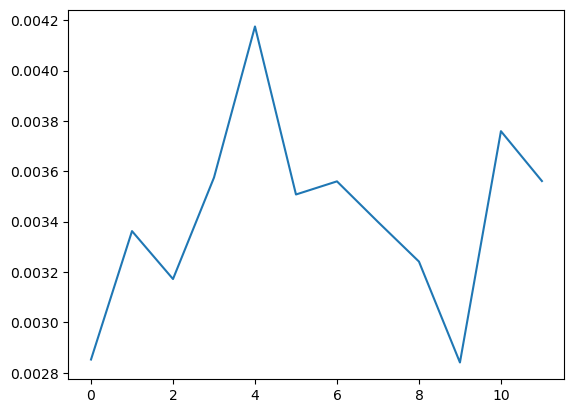

In [12]:
plt.plot(average_loss_all)